# Salary Prediction from LinkedIn Job Postings - Train Gradient Boosting Model

In [13]:
import xgboost as xgb
import pandas as pd, numpy as np
import salary
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
import joblib

In [2]:
sns.set_theme()

## Train & Evaluate Models

In [3]:
(X_train, y_train) = salary.get_train_dataset()
(X_test, y_test) = salary.get_test_dataset()

In [4]:
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('one_hot_encoder', OneHotEncoder(use_cat_names=True), ['norm_title', 'clustered_edu_req', 'clustered_pref_qual', 'clustered_req_skill', 'location_state', 'company_industries', 'formatted_experience_level', 'formatted_work_type']),
            ('target_encoder', TargetEncoder(), ['norm_title', 'clustered_edu_req', 'clustered_pref_qual', 'clustered_req_skill', 'location_state', 'company_industries', 'formatted_experience_level', 'formatted_work_type']),
            ('experience_level', salary.experience_level_encoder, ['formatted_experience_level']),
            ('work_type', salary.work_type_encoder, ['formatted_work_type']),
            ('remote_allowed', 'passthrough', ['remote_allowed']),
            ('company_employee_count', SimpleImputer(strategy='median'), ['company_employee_count']),
        ],
        remainder='drop'
    ),
    StandardScaler(),
)

### XGBoost

In [5]:
model_xgb = make_pipeline(
    clone(preprocessor),
    BayesSearchCV(
        estimator=xgb.XGBRegressor(n_estimators=500, objective='reg:squarederror', random_state=42),
        search_spaces={
            'max_depth': (3, 7),
            'min_child_weight': (5, 15),  
            'eta': (0.005, 0.1, 'log-uniform'), 
            'subsample': (0.5, 0.9),
            'colsample_bytree': (0.5, 0.9), 
            'gamma': (0, 5),  
            'reg_alpha': (0.1, 100, 'log-uniform'), 
            'reg_lambda': (0.1, 100, 'log-uniform')  
        },
        scoring='r2',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_iter=50, 
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [6]:
model_xgb

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('one_hot_encoder',
                                                                   OneHotEncoder(use_cat_names=True),
                                                                   ['norm_title',
                                                                    'clustered_edu_req',
                                                                    'clustered_pref_qual',
                                                                    'clustered_req_skill',
                                                                    'location_state',
                                                                    'company_industries',
                                                                    'formatted_experience_level',
                                                                    'formatted_work_type']),
                                                                  ('target_encoder',
                                                                   TargetEncoder...
                                                      multi_strategy=None,
                                                      n_estimators=500,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...),
                               n_jobs=-1, random_state=42, scoring='r2',
                               search_spaces={'colsample_bytree': (0.5, 0.9),
                                              'eta': (0.005, 0.1,
                                                      'log-uniform'),
                                              'gamma': (0, 5),
                                              'max_depth': (3, 7),
                                              'min_child_weight': (5, 15),
                                              'reg_alpha': (0.1, 100,
                                                            'log-uniform'),
                                              'reg_lambda': (0.1, 100,
                                                             'log-uniform'),
                                              'subsample': (0.5, 0.9)},
                               verbose=1))])

In [ ]:
result_xgb_train = salary.evaluate_train_predictions(model_xgb.predict(X_train))
result_xgb_test = salary.evaluate_test_predictions(model_xgb.predict(X_test))

Train R2: 0.7625
Train RMSE: 29978.3095
Train MAE: 19438.3895
Test R2: 0.5631
Test RMSE: 38532.9194
Test MAE: 25056.5293


In [8]:
'''
Check best hyperparameters and their CV R^2
'''
bayes_search = model_xgb[-1]
cv_results_df = pd.DataFrame(bayes_search.cv_results_)
cv_results_df.sort_values(by='mean_test_score', ascending=False).head(5)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
36,0.493323,0.016625,"{'colsample_bytree': 0.5, 'eta': 0.1, 'gamma':..."
30,0.492595,0.017825,"{'colsample_bytree': 0.5, 'eta': 0.1, 'gamma':..."
43,0.492068,0.018740,"{'colsample_bytree': 0.6473638571355855, 'eta'..."
35,0.491098,0.014754,"{'colsample_bytree': 0.5, 'eta': 0.08204578930..."
18,0.490384,0.015001,"{'colsample_bytree': 0.5, 'eta': 0.05207242358..."


## Train & Evaluate Best Model

In [9]:
best_params = bayes_search.best_params_
best_model = make_pipeline(
    clone(preprocessor),
    xgb.XGBRegressor(n_estimators=500, objective='reg:squarederror', random_state=42, **best_params),
).fit(X_train, y_train)

In [10]:
results_train = salary.evaluate_train_predictions(best_model.predict(X_train))
result_test = salary.evaluate_test_predictions(best_model.predict(X_test))

Train R2: 0.7625
Train RMSE: 29978.3095
Train MAE: 19438.3895
Test R2: 0.5631
Test RMSE: 38532.9194
Test MAE: 25056.5293


,Feature,Importance
0,one_hot_encoder__company_industries_Legal Services,0.029359
1,one_hot_encoder__formatted_experience_level_Entry level,0.024428
2,target_encoder__norm_title,0.02047
3,experience_level__formatted_experience_level,0.019217
4,one_hot_encoder__formatted_experience_level_Executive,0.01906
5,target_encoder__formatted_experience_level,0.018859
6,one_hot_encoder__formatted_experience_level_Director,0.017066
7,one_hot_encoder__clustered_edu_req_High school diploma or equivalent,0.012796
8,target_encoder__company_industries,0.012671
9,one_hot_encoder__formatted_experience_level_Associate,0.012474


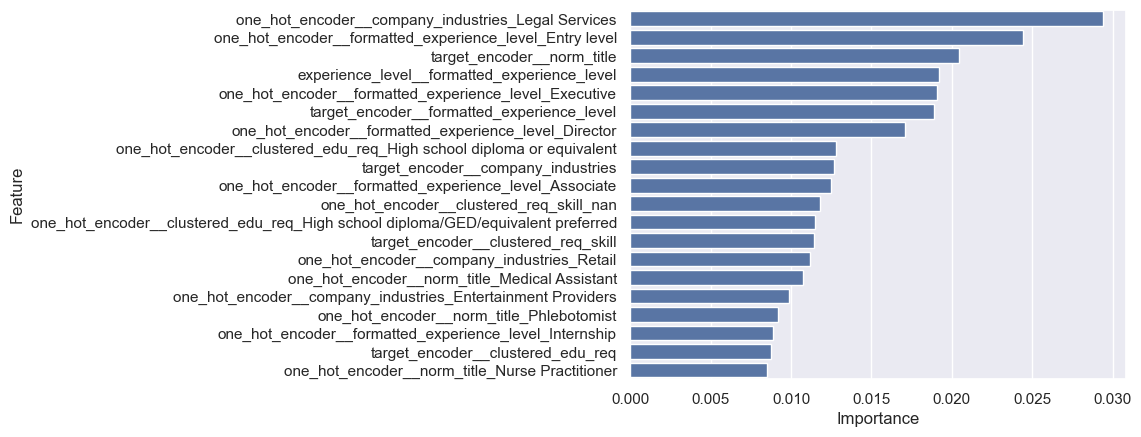

In [16]:
'''
Show top 20 important features
'''

def get_important_features(preocessor, model, n=20):
    feature_names = preocessor.get_feature_names_out(X_train.columns)
    importances = model.feature_importances_
    idxs = np.flip(np.argsort(np.abs(importances)))
    importance_df = pd.DataFrame([feature_names[idxs], importances[idxs]], index=["Feature", "Importance"]).transpose()
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(n))
    pd.set_option('display.max_colwidth', None)
    return importance_df[:n]


get_important_features(best_model[0], best_model[-1])

## Export Best Model

In [14]:
joblib.dump(best_model, 'models/best_model_gradient_boosting.pkl')

['models/best_model_gradient_boosting.pkl']